In [3]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from datetime import datetime

In [13]:
df = pd.read_csv('landmarks_dataset_balanced__M_A_W_H.csv')
print(df)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
X = df.drop('label', axis=1).values
y = df['label'].values

      Unnamed: 0    0    1    2    3    4    5    6    7    8  ...  231  232  \
0           2684  398  334  407  238  397  270  407  210  402  ...  412  483   
1            665  326  386  319  296  321  324  317  268  316  ...  504  441   
2            291  320  399  324  307  324  335  325  279  326  ...  505  426   
3          13742  304  400  308  314  309  340  309  285  310  ...  523  411   
4           8797  304  387  303  275  304  311  304  246  306  ...  465  427   
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
5849        1953  338  309  345  219  341  257  346  196  347  ...  405  452   
5850       11690  304  364  311  261  310  299  312  232  314  ...  461  394   
5851       11788  349  372  341  285  342  313  339  258  335  ...  472  439   
5852       12121  336  383  331  280  333  312  330  251  328  ...  459  440   
5853       10678  307  372  316  257  314  298  318  227  320  ...  461  415   

      233  234  235  236  237  238  239

In [14]:
print(df)
print(y)
print(len(y))
print(len(X))
print(len(X[0]))

        0    1    2    3    4    5    6    7    8    9  ...  231  232  233  \
0     398  334  407  238  397  270  407  210  402  175  ...  412  483  368   
1     326  386  319  296  321  324  317  268  316  232  ...  504  441  412   
2     320  399  324  307  324  335  325  279  326  242  ...  505  426  429   
3     304  400  308  314  309  340  309  285  310  246  ...  523  411  433   
4     304  387  303  275  304  311  304  246  306  211  ...  465  427  412   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
5849  338  309  345  219  341  257  346  196  347  171  ...  405  452  345   
5850  304  364  311  261  310  299  312  232  314  198  ...  461  394  416   
5851  349  372  341  285  342  313  339  258  335  223  ...  472  439  404   
5852  336  383  331  280  333  312  330  251  328  214  ...  459  440  413   
5853  307  372  316  257  314  298  318  227  320  192  ...  461  415  416   

      234  235  236  237  238  239  label  
0     457  372  452

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
models = {
    'XGBoost': (XGBClassifier(eval_metric='logloss'), {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }),
    
}
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted')
}

In [10]:
results = []
best_models = {}
start_time = time.time()

def create_filename_from_params(model_name, params):
    params_str = '_'.join([f"{key}={val}" for key, val in params.items()])
    filename = f"trained_{model_name}_model_{params_str}.joblib"
    filename = filename.replace(':', '-').replace(' ', '_').replace(',', '')
    return filename

for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring=scoring, refit='accuracy', return_train_score=True, n_jobs= -1)
    grid_search.fit(X_train, y_train)

    best_models[model_name] = grid_search.best_estimator_

    num_splits = len([key for key in grid_search.cv_results_.keys() if key.startswith('split') and key.endswith('_test_accuracy')])

    for i in range(len(grid_search.cv_results_['mean_test_accuracy'])):
        params = grid_search.cv_results_['params'][i]
        mean_accuracy = grid_search.cv_results_['mean_test_accuracy'][i]
        mean_precision = grid_search.cv_results_['mean_test_precision'][i]
        mean_recall = grid_search.cv_results_['mean_test_recall'][i]
        mean_fit_time = grid_search.cv_results_['mean_fit_time'][i]
        mean_score_time = grid_search.cv_results_['mean_score_time'][i]
        total_training_time = mean_fit_time + mean_score_time

        split_scores = {f'split{split_idx}_test_accuracy': grid_search.cv_results_[f'split{split_idx}_test_accuracy'][i] for split_idx in range(num_splits)}
        split_precisions = {f'split{split_idx}_test_precision': grid_search.cv_results_[f'split{split_idx}_test_precision'][i] for split_idx in range(num_splits)}
        split_recalls = {f'split{split_idx}_test_recall': grid_search.cv_results_[f'split{split_idx}_test_recall'][i] for split_idx in range(num_splits)}

        result = {
            'model': model_name,
            'params': params,
            'mean_test_accuracy': mean_accuracy,
            'mean_test_precision': mean_precision,
            'mean_test_recall': mean_recall,
            'mean_fit_time': mean_fit_time,
            'mean_score_time': mean_score_time,
            'total_training_time': total_training_time
        }
        result.update(split_scores)
        result.update(split_precisions)
        result.update(split_recalls)

        results.append(result)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {model_name}: {grid_search.best_score_}")
    
    best_params = grid_search.best_params_
    model_filename = f'TrainnedModel/{create_filename_from_params(model_name, best_params)}'
    joblib.dump(grid_search.best_estimator_, model_filename)
    print(f"Model saved as {model_filename}")

results_df = pd.DataFrame(results)
results_df.to_excel('grid_search_results_ALL_KNN_RF_XG.xlsx', index=False)

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print('Locals Testing Session')

Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation accuracy for KNN: 0.8819159696025368
Model saved as TrainnedModel/trained_KNN_model_metric=euclidean_n_neighbors=3_weights=distance.joblib
Best parameters for RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy for RandomForest: 0.8872528383722413
Model saved as TrainnedModel/trained_RandomForest_model_max_depth=None_min_samples_split=2_n_estimators=300.joblib
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
Best cross-validation accuracy for XGBoost: 0.8968591110382155
Model saved as TrainnedModel/trained_XGBoost_model_learning_rate=0.2_max_depth=7_n_estimators=300.joblib
Elapsed time: 558.0631105899811 seconds
Locals Testing Session


Test accuracy for KNN: 0.8898377455166524
Test precision for KNN: 0.8928204534387953
Test recall for KNN: 0.8872826532404425
Test accuracy for RandomForest: 0.8975234842015372
Test precision for RandomForest: 0.8993285813917751
Test recall for RandomForest: 0.8955506117908787
Test accuracy for XGBoost: 0.9052092228864219
Test precision for XGBoost: 0.9054878227828773
Test recall for XGBoost: 0.9042225279550378


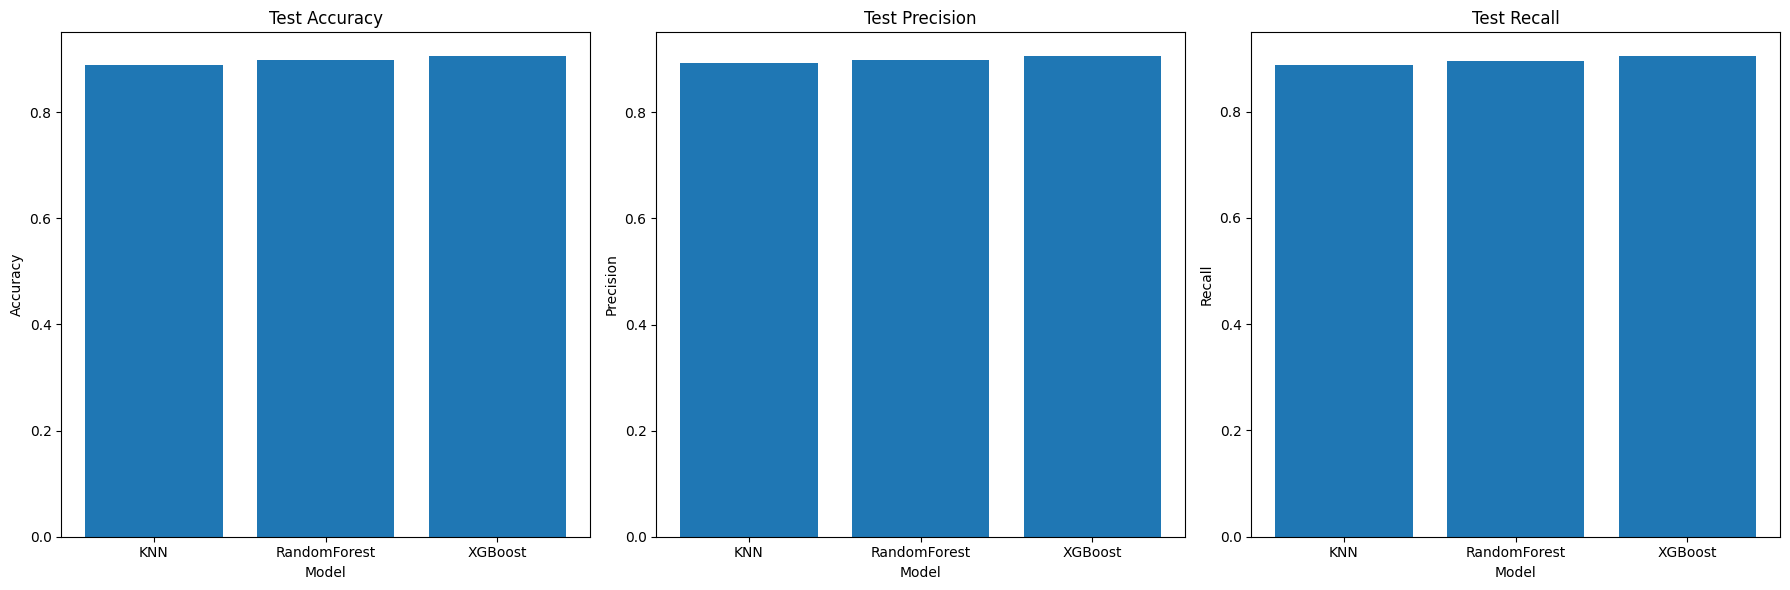

Elapsed time: 0.7874405384063721 seconds
Locals Testing Session


In [12]:
start_time = time.time()
test_results = []
for model_name, best_model in best_models.items():
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred, average='macro')
    test_recall = recall_score(y_test, y_pred, average='macro')
    
    test_result = {
        'model': model_name,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall
    }
    test_results.append(test_result)
    print(f"Test accuracy for {model_name}: {test_accuracy}")
    print(f"Test precision for {model_name}: {test_precision}")
    print(f"Test recall for {model_name}: {test_recall}")

test_results_df = pd.DataFrame(test_results)
test_results_df.to_excel('TestResult/test_results_All_KNN_RF_XG.xlsx', index=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].bar(test_results_df['model'], test_results_df['test_accuracy'])
axes[0].set_title('Test Accuracy')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Accuracy')

axes[1].bar(test_results_df['model'], test_results_df['test_precision'])
axes[1].set_title('Test Precision')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Precision')

axes[2].bar(test_results_df['model'], test_results_df['test_recall'])
axes[2].set_title('Test Recall')
axes[2].set_xlabel('Model')
axes[2].set_ylabel('Recall')


current_datetime = datetime.now().strftime('%Y%m%d_%H%M%S')
plt.tight_layout()
plt.savefig(f'TestResult/test_results_plot_KNN_RF_XG{current_datetime}.png')  
plt.show()

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print('Locals Testing Session')